## PHY 410
### GPS Final Project
### Jeremy Kazimer

***

### Import Statements

In [1]:
# Python libraries:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

# Appending a path to get to utility files:
import sys
sys.path.append('utility')

# My utility libraries:
from get_data import *
from geographical_to_cartesian import *
from least_squares import *

### Experiments
##### Converting the data to a sensible form

We begin the experiments by first loading a random dataset from the set of four files I recorded on December 3rd, 2020:

In [52]:
# np.random.choice([1, 2, 3, 4]) picks an integer randomly from 1 - 4.
# .format() inserts that choice into the string at {}
filename = 'data/sample_{}.csv'.format(np.random.choice([7]))

print('working file: {}'.format(filename))

working file: data/sample_7.csv


Then, using my first helper library `get_data`, we load in the data in the form of a dictionary storing all the information that we care about:

In [30]:
position_dictionary = get_data(filename, ignore_zeros = True)

In [31]:
# Printing the keys, just to show what was stored:
print(position_dictionary.keys())

dict_keys(['time', 'latitude', 'longitude', 'altitude', 'z std', 'x & y std'])


Just to see the data in the geographical coordinate system, we can plot the main variables first as a function of time, then each other:

In [32]:
# Fetching the appropriate variables.
time = position_dictionary['time']

latitude = position_dictionary['latitude']
longitude = position_dictionary['longitude']
altitude = position_dictionary['altitude']

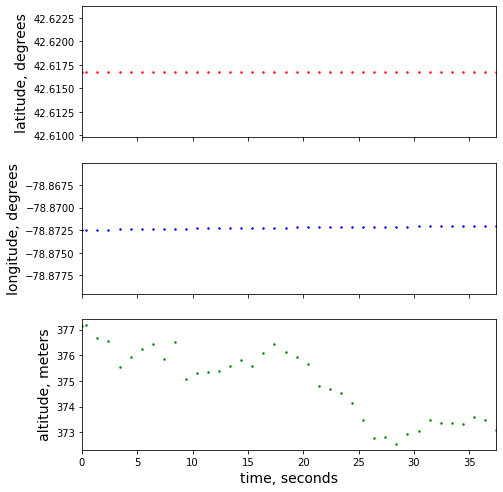

In [33]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, latitude, s = 2, c = 'red')
axs[1].scatter(time, longitude, s = 2, c = 'blue')
axs[2].scatter(time, altitude, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('latitude, degrees', fontsize = 14)
axs[1].set_ylabel('longitude, degrees', fontsize = 14)
axs[2].set_ylabel('altitude, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_geographical_plot.pdf')

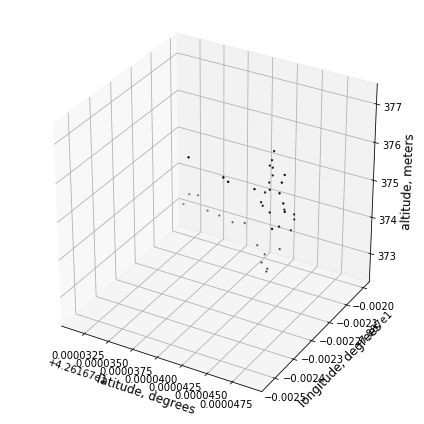

In [34]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(latitude, longitude, altitude, s = 2, c = 'k')

# Labels:
ax.set_xlabel('latitude, degrees', fontsize = 12)
ax.set_ylabel('longitude, degrees', fontsize = 12)
ax.set_zlabel('altitude, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_geographical_plot.pdf')

# Sorry for the "longitude" label.  I couldn't seem to move it.

This plot is fine and all, but, aforementioned, it means nothing to the average person for two reasons.  First, that it's in an unconventional coordinate system for everyday use.  We can address this by converting the system to Cartesian.  For this, we'll use the `geographical_to_cartesian` library (see *Theory* for explanation):

In [35]:
cartesian_system = convert_coordinates(latitude, longitude, altitude)

In [36]:
# Once again, printing the keys for convenience.
print(cartesian_system.keys())

dict_keys(['x', 'y', 'z'])


In [37]:
x, y, z = cartesian_system['x'], cartesian_system['y'], cartesian_system['z']

We can now repeat the same plots above, but for the new coordinate system:

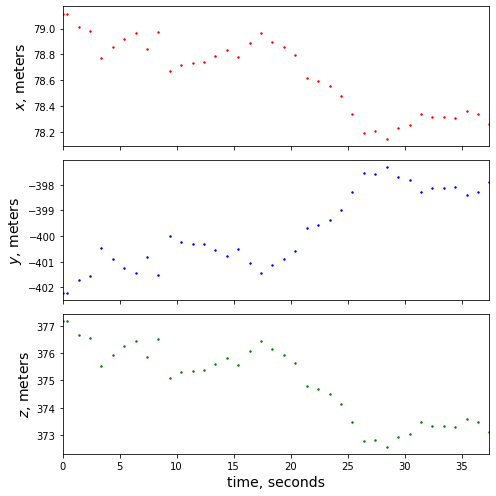

In [38]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, x, s = 2, c = 'red')
axs[1].scatter(time, y, s = 2, c = 'blue')
axs[2].scatter(time, z, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$x$, meters', fontsize = 14)
axs[1].set_ylabel('$y$, meters', fontsize = 14)
axs[2].set_ylabel('$z$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_cartesian_plot.pdf')

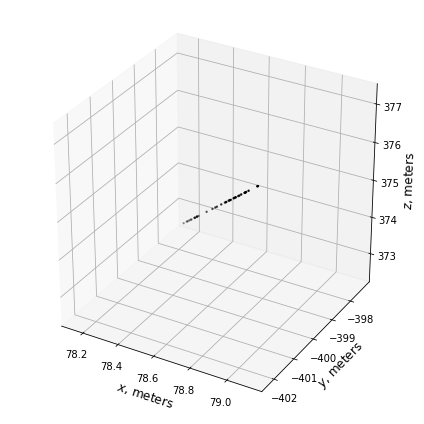

In [39]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(x, y, z, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$x$, meters', fontsize = 12)
ax.set_ylabel('$y$, meters', fontsize = 12)
ax.set_zlabel('$z$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_cartesian_plot.pdf')

This is fine.  With a little more knowledge, the user can understand that they're moving away from their starting point.  However, my second concern arises:  although it's fine that the origin is not defined by the starting point, it doesn't make much sense to not shift the data to the starting point.

To me, this is because shifting to the origin tells the user a lot more information without additional thought.  For example, "you are 10 meters down from home" is more sensical than "you are at 250 meters in the $z$".  

As such, the conversion is generically $ds = s - s_0$, where $s$ is any generic position variable and $s_0$ is the first point in this set.  Then, $dn$ is simply the change in that variable at any given point.  In Python:

In [40]:
dx = x - x[0]
dy = y - y[0]
dz = z - z[0]

And a demonstrative plot:

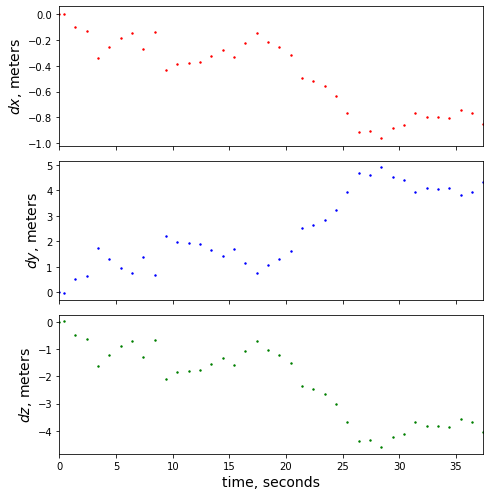

In [41]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, dx, s = 2, c = 'red')
axs[1].scatter(time, dy, s = 2, c = 'blue')
axs[2].scatter(time, dz, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$dx$, meters', fontsize = 14)
axs[1].set_ylabel('$dy$, meters', fontsize = 14)
axs[2].set_ylabel('$dz$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_relative_cartesian_plot.pdf')

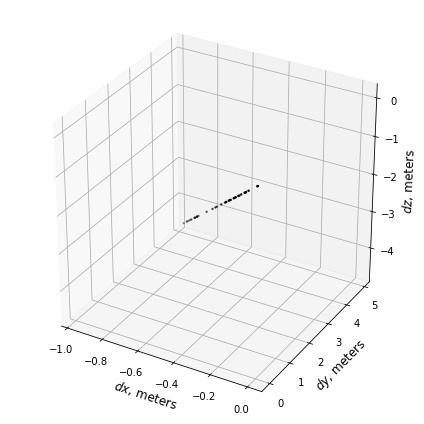

In [42]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(dx, dy, dz, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$dx$, meters', fontsize = 12)
ax.set_ylabel('$dy$, meters', fontsize = 12)
ax.set_zlabel('$dz$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_relative_cartesian_plot.pdf')

As suggested, the structure of the data doesn't really change that much (see _Theory_ for more).  To me, this is more interpretable for the average person.  Of course, it's unrealistic that the average person will see this, but it's far more reasonable to cater to the average than to the deviations.

Now, since we've established our coordinate system, we can begin fitting the data.

##### Fitting the univariate data

The question then arises of how to fit the data.  First, it depends on what exactly is being predicted.  In the most basic case, $f(t)$ is a useful quantity to predict - it tells you where you should be as a function of time.  

Since time is purely linear (although this year has felt the opposite), we'll utilize least-squares (see `Theory`) to fit our model:

In [43]:
# By putting it in an array, we don't have to repeat code.
ds_array = [dx, dy, dz]

# Recall that position_dictionary came from the beginning and 
# stores the std's alongside the geographical coordinates.
std_array = [position_dictionary['x & y std'], 
             position_dictionary['x & y std'],
             position_dictionary['z std']]

# 3 coefficients, 3 dimensions.
coefficients = np.zeros((3, 4))

for idx, ds in enumerate(ds_array):

    std_ds = std_array[idx]

    quadratic_coefficients = least_squares(ds, time, n = 3)
    
    coefficients[idx] = quadratic_coefficients

And now, a simple plot as demonstration:

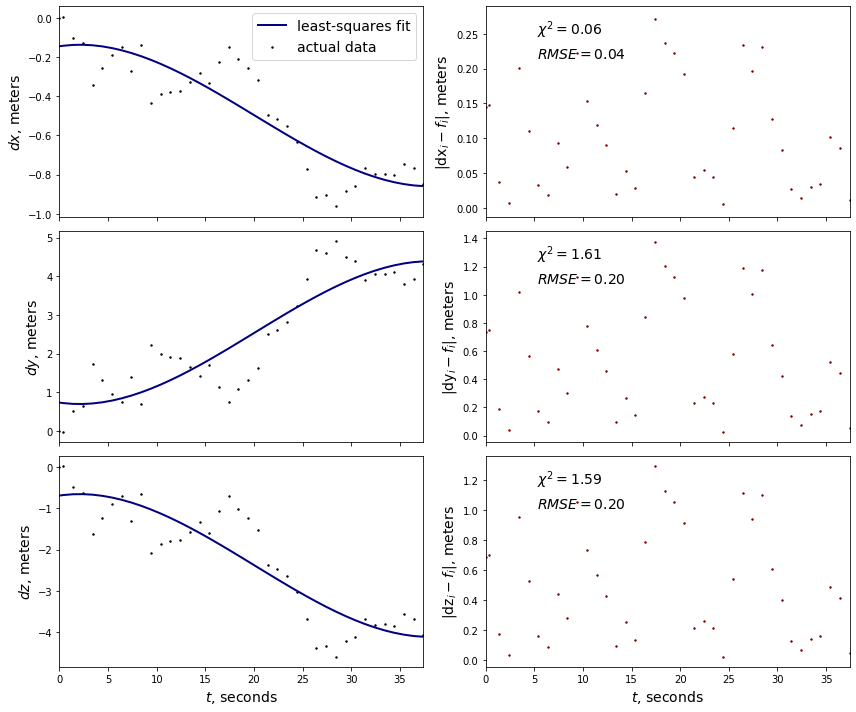

In [44]:
labels = [r'$dx$', r'$dy$', r'$dz$']

fig, axs = plt.subplots(3, 2, sharex = True, figsize = (12, 10))

for idx, label in enumerate(labels):
    
    # Pulling the prediction.  They stored in ascending power:
    coeff = coefficients[idx]
    fit = np.sum([coeff[idx]*time**idx for idx in range(len(coeff))], axis = 0)
    
    # First, the comparison of functions:
    axs[idx][0].scatter(time, ds_array[idx], s = 2, c = 'k', label = 'actual data')
    axs[idx][0].plot(time, fit, lw = 2, c = 'navy', label = 'least-squares fit')
    
    axs[idx][0].set_ylabel(label + ', meters', fontsize = 14)
    
    # Then the error:
    axs[idx][1].scatter(time, abs(ds_array[idx] - fit), c = 'maroon', s = 2)
    
    axs[idx][1].set_ylabel('$|{}_i - {}|$, meters'.format(label, 'f_i'), fontsize = 14)
    
    # Spoofing a legend to insert chi2:
    axs[idx][1].scatter(time[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$\chi^2 = {:.2f}$'.format(chi2(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].scatter(time[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$RMSE = {:.2f}$'.format(rmse(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    if idx == 2:
        axs[idx][0].set_xlabel('$t$, seconds', fontsize = 14)
        axs[idx][1].set_xlabel('$t$, seconds', fontsize = 14)
    
    axs[idx][0].set_xlim(time[0], time[-1])
    axs[idx][1].set_xlim(time[0], time[-1])
    
axs[0][0].legend(loc = 'upper right', fontsize = 14)
    
fig.tight_layout()

For large data, we see that the fit is pretty good.  However, since this predicts a physical system, we can print the coefficients such that we know initial acceleration, velocity, etc.:

In [45]:
coeff_dx = coefficients[0]
labels = ['position', 'velocity', 'acceleration', 'jerk']
units = ['m', 'm/s', 'm/s^2', 'm/s^3']

for idx, label in enumerate(labels):
    current_constant = 'initial {} in dx: {} {}'.format(label, coeff_dx[idx], units[idx])
    print(current_constant)

initial position in dx: -0.14452034280401332 m
initial velocity in dx: 0.007527117305290085 m/s
initial acceleration in dx: -0.0018792671907807944 m/s^2
initial jerk in dx: 3.121296530800893e-05 m/s^3


In [46]:
coeff_dy = coefficients[1]
labels = ['position', 'velocity', 'acceleration', 'jerk']
units = ['m', 'm/s', 'm/s^2', 'm/s^3']

for idx, label in enumerate(labels):
    current_constant = 'initial {} in dy: {} {}'.format(label, coeff_dy[idx], units[idx])
    print(current_constant)

initial position in dy: 0.7358644708033586 m
initial velocity in dy: -0.03730608985594043 m/s
initial acceleration in dy: 0.00952564768053881 m/s^2
initial jerk in dy: -0.00015825228630733266 m/s^3


In [47]:
coeff_dz = coefficients[2]
labels = ['position', 'velocity', 'acceleration', 'jerk']
units = ['m', 'm/s', 'm/s^2', 'm/s^3']

for idx, label in enumerate(labels):
    current_constant = 'initial {} in dz: {} {}'.format(label, coeff_dz[idx], units[idx])
    print(current_constant)

initial position in dz: -0.6899885234301552 m
initial velocity in dz: 0.035015753864714894 m/s
initial acceleration in dz: -0.008933209215078055 m/s^2
initial jerk in dz: 0.000148403626925234 m/s^3


##### Fitting the multivariate data

We can now repeat the process, but this time treating $r = f(x, y, z)$ such that we can fit the data. 

Vague equation:

$r(t) \approx c_1 + c_2 x(t) + c_3 y(t) + c_3 z(t)$

which can be translated into a least-squares matrix $T$ such that

$A = \begin{bmatrix} 1 & \vec x(t) & \vec y(t) & \vec z(t) \end{bmatrix}$

In [48]:
dr = np.sqrt(dx**2 + dy**2 + dz**2)

A = np.array((np.ones(len(dr)), dx, dy, dz)).T
a,b,c,d = np.linalg.solve(A.T @ A, A.T @ dr)

In [49]:
chi2(dr, a + b*dx + c*dy + d*dz, 1)

0.004174164197202565

In [50]:
A = np.array((dx, dy, dz)).T
np.linalg.solve(A.T @ A, A.T @ dr)

array([  9.08705236, -40.97103113, -47.07363026])

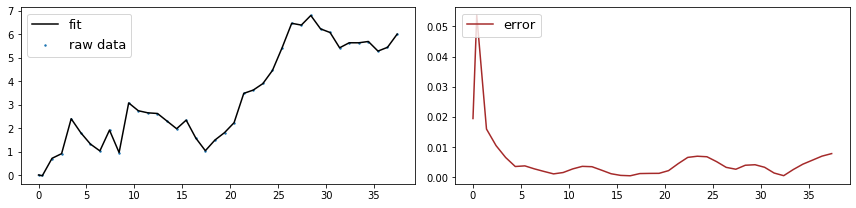

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0].scatter(time, dr, s = 2, label = 'raw data')
ax[0].plot(time, a + b*dx + c*dy + d*dz, c = 'k', label = 'fit')
ax[0].legend(loc = 'upper left', fontsize = 13)
ax[1].plot(time, abs(dr - (a + b*dx + c*dy + d*dz)), c = 'brown', label = 'error')
ax[1].legend(loc = 'upper left', fontsize = 13)

fig.tight_layout()

### Notes

https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704-ep713_multivariablemethods/bs704-ep713_multivariablemethods2.html